Regression Model for 1.1

Data Loaded Successfully. Time Series Shape: (34,)
Training Samples: 29 | Test Samples: 5

Model Trained Successfully.
                                     SARIMAX Results                                      
Dep. Variable:     Total greenhouse gas emissions   No. Observations:                   29
Model:                             ARIMA(1, 1, 1)   Log Likelihood                -122.299
Date:                            Wed, 19 Nov 2025   AIC                            250.597
Time:                                    19:33:23   BIC                            254.594
Sample:                                01-01-1990   HQIC                           251.819
                                     - 01-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------

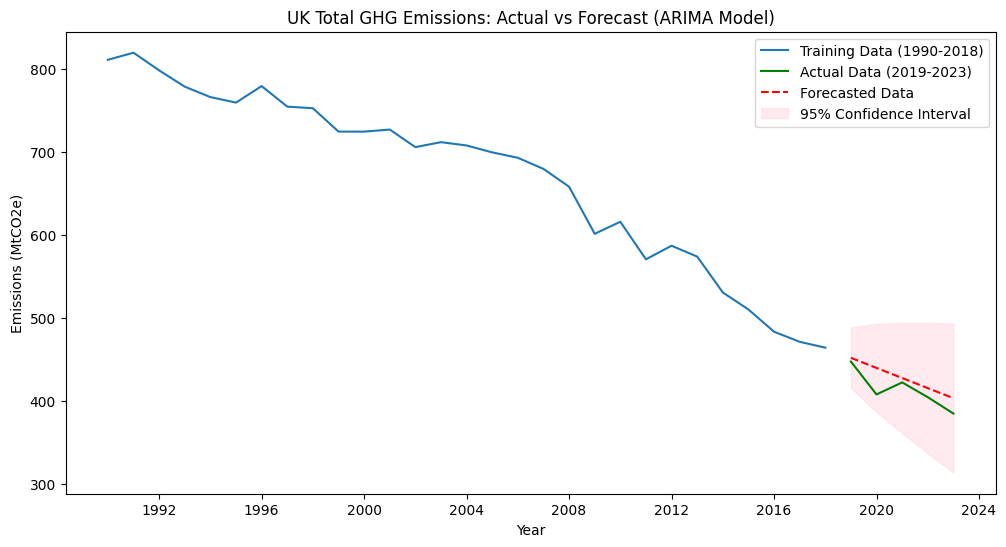


Final model trained on all data and saved as 'arima_ghg_model.pkl'


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# --- 1. Data Loading & Preprocessing ---
file_path = 'final-greenhouse-gas-emissions-tables-2023.xlsx'

# Load Table 1.1
df = pd.read_excel(file_path, sheet_name='1.1', header=5)
df.rename(columns={df.columns[0]: 'Gas'}, inplace=True)
df.set_index('Gas', inplace=True)

# Clean Column Headers (Force Years to Integers)
df.columns = pd.to_numeric(df.columns, errors='coerce')
df = df.dropna(axis=1, how='all')
df.columns = df.columns.astype(int)
df.dropna(how='all', inplace=True)

# Isolate the Target Variable: Total Emissions
target_series = df.loc['Total greenhouse gas emissions']

# Transpose to create a Time Series (Index=Year, Value=Emissions)
# Ensure index is proper Datetime format for Statsmodels (usually requires frequency info)
# However, for annual data, integer index often works, but datetime is safer.
ts_data = target_series.T
ts_data.index = pd.date_range(start=str(ts_data.index[0]), periods=len(ts_data), freq='AS') # Annual Start (Jan 1st)
ts_data = ts_data.astype(float)

print("Data Loaded Successfully. Time Series Shape:", ts_data.shape)

# --- 2. Train-Test Split ---
# We will split manually to respect the time order (e.g., Train on 1990-2018, Test on 2019-2023)
split_year = '2018-01-01'
train = ts_data[:split_year]
test = ts_data['2019-01-01':]

print(f"Training Samples: {len(train)} | Test Samples: {len(test)}")

# --- 3. Model Training (ARIMA) ---
# We use ARIMA (AutoRegressive Integrated Moving Average)
# Order (1,1,1) is a standard starting point for non-stationary annual data.
# (p=1: AutoRegressive term, d=1: Differencing to remove trend, q=1: Moving Average)
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()

print("\nModel Trained Successfully.")
print(model_fit.summary())

# --- 4. Evaluation ---
# Forecast for the length of the test set
forecast_result = model_fit.get_forecast(steps=len(test))
forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# Metrics
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))

print(f"\nModel Accuracy Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f} MtCO2e")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} MtCO2e")

# --- 5. Visualization ---
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data (1990-2018)')
plt.plot(test.index, test, label='Actual Data (2019-2023)', color='green')
plt.plot(test.index, forecast, label='Forecasted Data', color='red', linestyle='--')
plt.fill_between(test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3, label='95% Confidence Interval')
plt.title('UK Total GHG Emissions: Actual vs Forecast (ARIMA Model)')
plt.xlabel('Year')
plt.ylabel('Emissions (MtCO2e)')
plt.legend()
plt.show()

# --- 6. Save the Model ---
# We refit the model on the ENTIRE dataset before saving for production use
final_model = ARIMA(ts_data, order=(1, 1, 1))
final_model_fit = final_model.fit()

model_filename = 'arima_ghg_model.pkl'
joblib.dump(final_model_fit, model_filename)
print(f"\nFinal model trained on all data and saved as '{model_filename}'")

Clustering Model for Table 1.2

Data Loaded: 8 sectors found.
['Electricity supply', 'Fuel supply', 'Domestic transport', 'Buildings and product uses', 'Industry', 'Agriculture', 'Waste', 'LULUCF']
Data Normalized.
Testing K range: [2, 3, 4, 5, 6, 7]


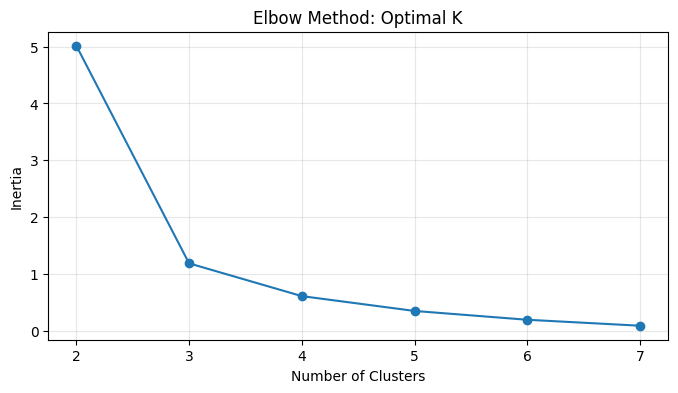


Model Trained (K=3). Silhouette Score: 0.592
Cluster Terminology Assigned:
                                     Cluster_Name
TES sector                                       
Domestic transport          Hard-to-Abate Sectors
Buildings and product uses  Hard-to-Abate Sectors
Agriculture                 Hard-to-Abate Sectors
Electricity supply              Moderate Reducers
Fuel supply                     Moderate Reducers
Industry                        Moderate Reducers
Waste                           Moderate Reducers
LULUCF                        Rapid Decarbonizers

Model saved as 'kmeans_clustering_model.pkl'


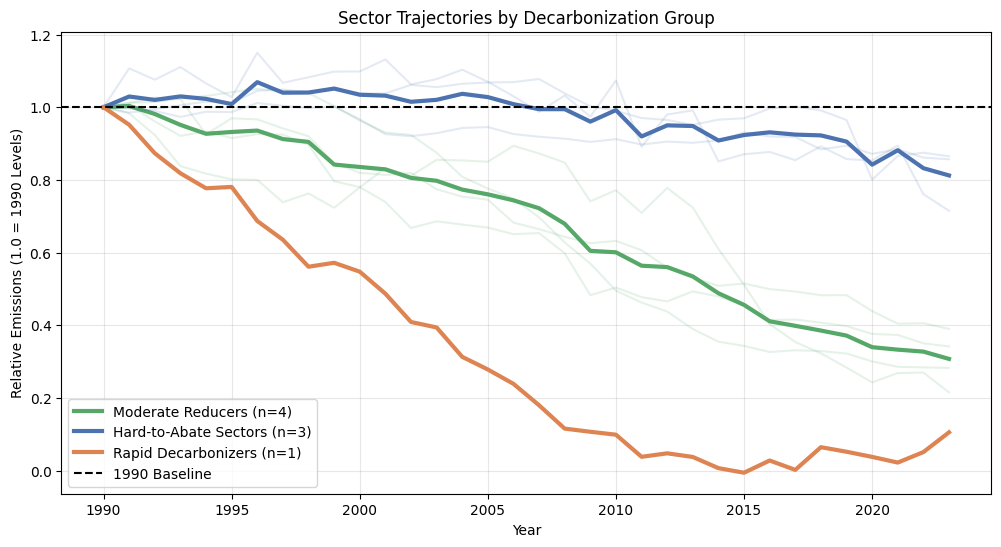

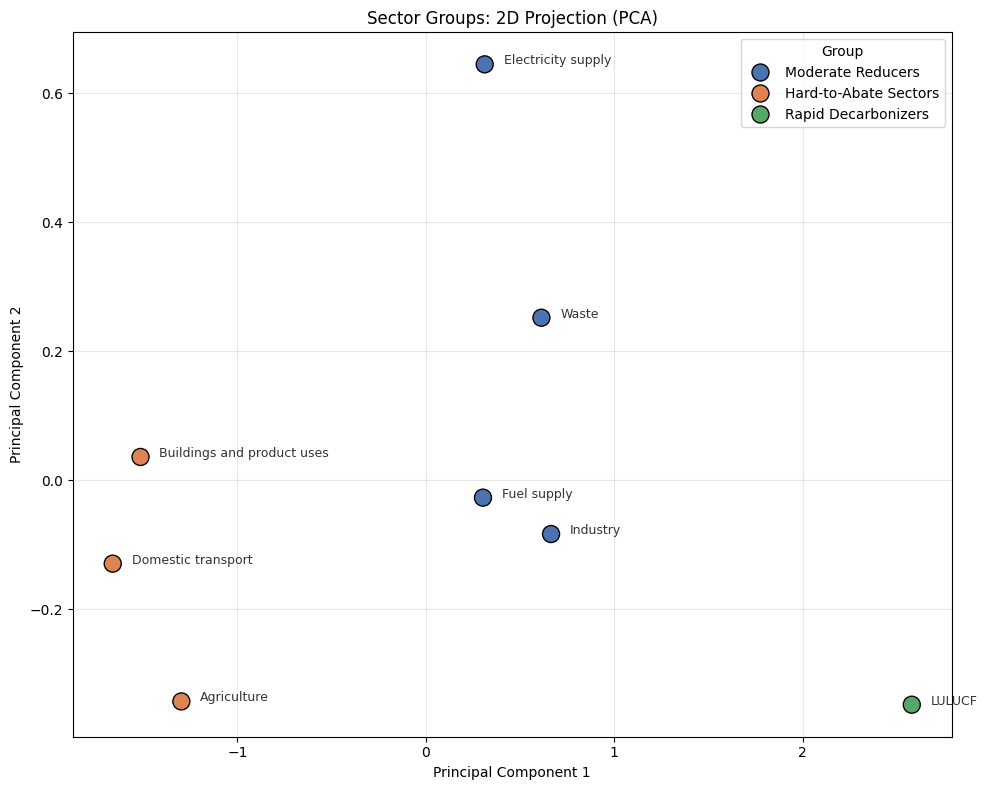

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import joblib
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# ==========================================
# 1. DATA LOADING & CLEANING
# ==========================================
file_path = 'final-greenhouse-gas-emissions-tables-2023.xlsx'

# Load Table 1.2
df_sectors = pd.read_excel(file_path, sheet_name='1.2', header=5)

# Clean column names
df_sectors.columns = [c if isinstance(c, int) else str(c).strip() for c in df_sectors.columns]

# Filter for Main Sectors
mask = (df_sectors['TES sector'].str.endswith(' total', na=False)) & \
       (df_sectors['TES sector'] != 'Grand total')
df_clean = df_sectors[mask].copy()

# Clean Sector Names
df_clean['TES sector'] = df_clean['TES sector'].str.replace(' total', '')
df_clean.set_index('TES sector', inplace=True)

# Keep only numeric Year columns and fix types
year_cols = [c for c in df_clean.columns if str(c).replace('.', '').isdigit()]
df_ts = df_clean[year_cols].copy()
df_ts.columns = pd.to_numeric(df_ts.columns).astype(int) # Force Integer Years
df_ts = df_ts.apply(pd.to_numeric, errors='coerce')

n_samples = df_ts.shape[0]
print(f"Data Loaded: {n_samples} sectors found.")
print(df_ts.index.tolist())

# ==========================================
# 2. FEATURE ENGINEERING: NORMALIZATION
# ==========================================
# Normalize (1990 = 1.0) to cluster by TRAJECTORY
start_vals = df_ts.iloc[:, 0].replace(0, 1e-9) 
df_norm = df_ts.div(start_vals, axis=0)
df_norm = df_norm.fillna(0)

print("Data Normalized.")

# ==========================================
# 3. DETERMINE OPTIMAL K (ELBOW METHOD)
# ==========================================
inertia = []

# Dynamic Range: Ensure max_k is strictly less than n_samples
max_k = min(8, n_samples) 
k_range = range(2, max_k)

print(f"Testing K range: {list(k_range)}")

if n_samples < 3:
    print("Not enough data points to generate an Elbow Plot.")
else:
    for k in k_range:
        km = KMeans(n_clusters=k, random_state=42, n_init=10)
        km.fit(df_norm)
        inertia.append(km.inertia_)

    plt.figure(figsize=(8, 4))
    plt.plot(k_range, inertia, marker='o')
    plt.title('Elbow Method: Optimal K')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.grid(True, alpha=0.3)
    plt.show()

# ==========================================
# 4. TRAIN FINAL MODEL & SMART NAMING
# ==========================================
# Select K (Default to 3 or 4, but cap at n_samples-1)
k_final = 3 
if k_final >= n_samples:
    k_final = max(2, n_samples - 1)
    print(f"Adjusted K to {k_final} due to sample size.")

# Train Model
kmeans = KMeans(n_clusters=k_final, random_state=42, n_init=10)
clusters = kmeans.fit_predict(df_norm)

# Add results
df_results = df_norm.copy()
df_results['Cluster_ID'] = clusters

# --- SMART NAMING LOGIC ---
# Analyze average '2023' value (relative to 1990) for each cluster
# Low value = Rapid reduction. High value = Hard to abate.
cluster_means = df_results.groupby('Cluster_ID').mean().iloc[:, -1] # Get 2023 column

# Create a mapping dictionary
cluster_names = {}
sorted_clusters = cluster_means.sort_values().index.tolist()

# Assign names based on rank
if len(sorted_clusters) >= 3:
    cluster_names[sorted_clusters[0]] = "Rapid Decarbonizers"  # Lowest 2023 value
    cluster_names[sorted_clusters[1]] = "Moderate Reducers"    # Middle value
    cluster_names[sorted_clusters[2]] = "Hard-to-Abate Sectors" # Highest value
    
    # If K > 3, map the rest generically
    for i in sorted_clusters[3:]:
        cluster_names[i] = f"Cluster {i}"
else:
    # Fallback for K=2
    cluster_names[sorted_clusters[0]] = "Leaders"
    cluster_names[sorted_clusters[1]] = "Laggards"

# Map the names to the dataframe
df_results['Cluster_Name'] = df_results['Cluster_ID'].map(cluster_names)

# Evaluation
sil_score = silhouette_score(df_norm, clusters)
print(f"\nModel Trained (K={k_final}). Silhouette Score: {sil_score:.3f}")

print("Cluster Terminology Assigned:")
print(df_results[['Cluster_Name']].sort_values(by='Cluster_Name'))

# ==========================================
# 5. SAVE THE MODEL
# ==========================================
joblib.dump(kmeans, 'kmeans_clustering_model.pkl')
print("\nModel saved as 'kmeans_clustering_model.pkl'")

# ==========================================
# 6. VISUALIZE CLUSTERS (TRAJECTORIES)
# ==========================================
plt.figure(figsize=(12, 6))
colors = sns.color_palette("deep", k_final)

# Iterate through Names
unique_names = df_results['Cluster_Name'].unique()

for i, name in enumerate(unique_names):
    subset = df_results[df_results['Cluster_Name'] == name]
    original_id = subset['Cluster_ID'].iloc[0]
    
    # Plot Centroid (Thick)
    # Note: iloc[:, :-2] excludes the last two columns (Cluster_ID and Cluster_Name)
    centroid = subset.iloc[:, :-2].mean(axis=0) 
    plt.plot(centroid.index, centroid.values, 
             color=colors[original_id], linewidth=3, 
             label=f'{name} (n={len(subset)})')
    
    # Plot Members (Thin)
    for sector in subset.index:
        plt.plot(subset.columns[:-2], subset.loc[sector, subset.columns[:-2]], 
                 color=colors[original_id], alpha=0.15)

plt.axhline(1.0, color='black', linestyle='--', label='1990 Baseline')
plt.title('Sector Trajectories by Decarbonization Group')
plt.ylabel('Relative Emissions (1.0 = 1990 Levels)')
plt.xlabel('Year')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ==========================================
# 7. VISUALIZE CLUSTERS (PCA SCATTER)
# ==========================================
# Run PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_norm)

# Create Plotting DF
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'], index=df_norm.index)
df_pca['Group'] = df_results['Cluster_Name']

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='PC1', y='PC2', 
    hue='Group', 
    data=df_pca, 
    palette='deep', 
    s=150, 
    edgecolor='black'
)

# Add Labels
for i in range(df_pca.shape[0]):
    plt.text(
        df_pca.PC1[i]+0.1, 
        df_pca.PC2[i], 
        df_pca.index[i], 
        fontsize=9, 
        alpha=0.8
    )

plt.title('Sector Groups: 2D Projection (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Table 1.7 Classification Model

Data Loaded: 12 unique fuel types found.

Class Distribution:
Trend_Class
Decreasing    8
Stable        3
Increasing    1
Name: count, dtype: int64

Model Accuracy: 0.75

Classification Report:
              precision    recall  f1-score   support

  Decreasing       0.75      1.00      0.86         3
      Stable       0.00      0.00      0.00         1

    accuracy                           0.75         4
   macro avg       0.38      0.50      0.43         4
weighted avg       0.56      0.75      0.64         4



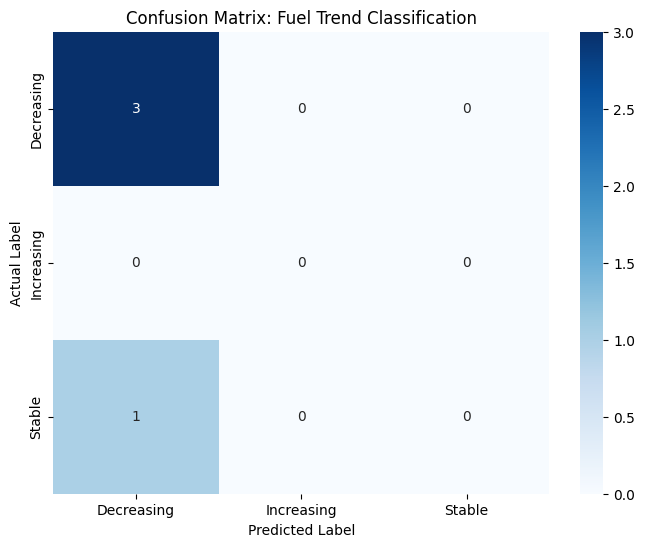

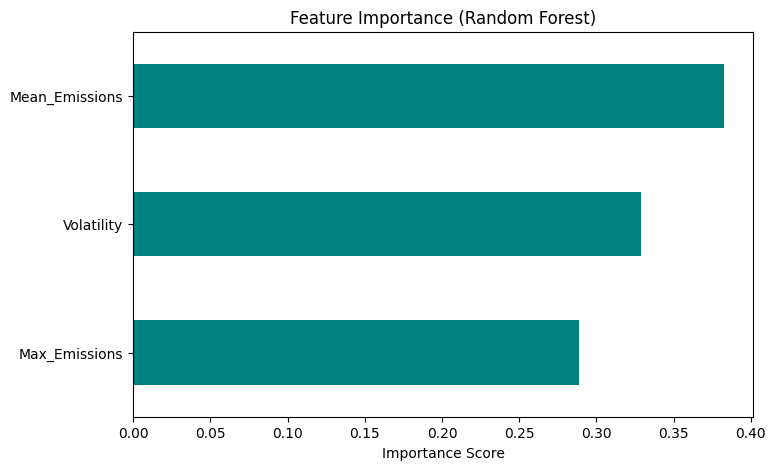

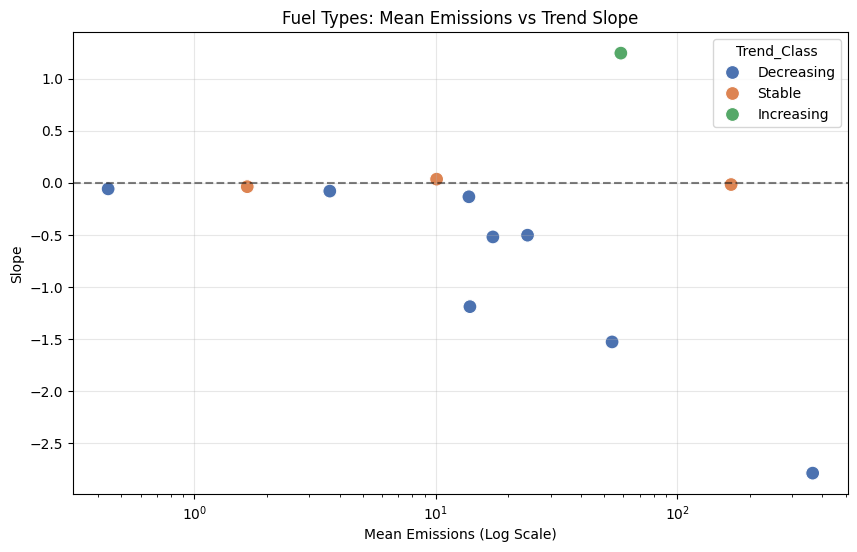


Model saved as 'fuel_classification_model.pkl'
Feature data saved as 'fuel_classification_features.csv'


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import joblib
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# ==========================================
# 1. DATA LOADING & CLEANING
# ==========================================
file_path = 'final-greenhouse-gas-emissions-tables-2023.xlsx'

# Load Table 1.7 (Header is usually row 4)
df_fuel = pd.read_excel(file_path, sheet_name='1.7', header=4)

# Clean column names
df_fuel.columns = [c if isinstance(c, int) else str(c).strip() for c in df_fuel.columns]

# Handle column naming variation if 'Fuel' column is missing
if 'Fuel' not in df_fuel.columns:
    # Sometimes the specific fuel type is in the second column
    df_fuel.rename(columns={df_fuel.columns[1]: 'Fuel'}, inplace=True)

# We want detailed 'Fuel' types (e.g., 'Petrol', 'Coal'), not just 'Fuel Group'
# Drop rows where 'Fuel' is null (often headers/footers)
df_clean = df_fuel.dropna(subset=['Fuel']).copy()

# Set Index to Fuel Name
df_clean['Fuel'] = df_clean['Fuel'].astype(str).str.strip()
# Remove duplicates if any (sum them up)
year_cols = [c for c in df_clean.columns if str(c).replace('.', '').isdigit()]
df_model_data = df_clean.groupby('Fuel')[year_cols].sum()

# Ensure numeric
df_model_data.columns = pd.to_numeric(df_model_data.columns).astype(int)
df_model_data = df_model_data.apply(pd.to_numeric, errors='coerce')

print(f"Data Loaded: {len(df_model_data)} unique fuel types found.")

# ==========================================
# 2. FEATURE ENGINEERING & LABELING
# ==========================================
# We need to create features (X) and a target label (y) for classification.

features = pd.DataFrame(index=df_model_data.index)

# Feature 1: Mean Emissions (Size)
features['Mean_Emissions'] = df_model_data.mean(axis=1)

# Feature 2: Volatility (Standard Deviation)
features['Volatility'] = df_model_data.std(axis=1)

# Feature 3: Max Emissions (Peak)
features['Max_Emissions'] = df_model_data.max(axis=1)

# Feature 4: Slope (The Trend) - Used to generate Ground Truth Labels
# We fit a linear line (y = mx + c) to get the slope 'm'
X_years = np.arange(len(year_cols))
slopes = []
for fuel in df_model_data.index:
    y_values = df_model_data.loc[fuel].values
    # Handle NaNs
    mask = ~np.isnan(y_values)
    if mask.sum() > 1:
        slope, intercept = np.polyfit(X_years[mask], y_values[mask], 1)
        slopes.append(slope)
    else:
        slopes.append(0)

features['Slope'] = slopes

# --- GENERATE LABELS (Ground Truth) ---
# We classify fuels based on their Slope
# Thresholds: < -0.1 (Decreasing), > 0.1 (Increasing), else (Stable)
def assign_label(slope):
    if slope < -0.05:
        return 'Decreasing'
    elif slope > 0.05:
        return 'Increasing'
    else:
        return 'Stable'

features['Trend_Class'] = features['Slope'].apply(assign_label)

print("\nClass Distribution:")
print(features['Trend_Class'].value_counts())

# ==========================================
# 3. MODEL TRAINING (Random Forest)
# ==========================================
# We will train the model to predict 'Trend_Class' using Mean, Volatility, and Max.
# (We exclude 'Slope' from X because it was used to define y directly).

X = features[['Mean_Emissions', 'Volatility', 'Max_Emissions']]
y = features['Trend_Class']

# Split Data (Small dataset, but standard practice)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ==========================================
# 4. VISUALIZATIONS
# ==========================================

# VIS 1: Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=rf_model.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.title('Confusion Matrix: Fuel Trend Classification')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# VIS 2: Feature Importance
plt.figure(figsize=(8, 5))
importances = pd.Series(rf_model.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', color='teal')
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance Score')
plt.show()

# VIS 3: Scatter Plot of Classes (Mean vs Slope)
# To visualize what the model is learning
plt.figure(figsize=(10, 6))
sns.scatterplot(data=features, x='Mean_Emissions', y='Slope', hue='Trend_Class', palette='deep', s=100)
plt.title('Fuel Types: Mean Emissions vs Trend Slope')
plt.axhline(0, color='black', linestyle='--', alpha=0.5)
plt.xscale('log') # Log scale helps visualize small and large fuels together
plt.xlabel('Mean Emissions (Log Scale)')
plt.grid(True, alpha=0.3)
plt.show()

# ==========================================
# 5. SAVE MODEL & DATA
# ==========================================
# Save the trained model
joblib.dump(rf_model, 'fuel_classification_model.pkl')

# Save the feature dataset (useful for dashboard display)
features.to_csv('fuel_classification_features.csv')

print("\nModel saved as 'fuel_classification_model.pkl'")
print("Feature data saved as 'fuel_classification_features.csv'")